In [1]:
# load the packages needed
import numpy as np

import sys
if "../" not in sys.path:
  sys.path.append("../")
from src.solver import Solver
from src.model import AR, MA
from src.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array

import src.data_processor as dp
import src.inference 
from src.ts_gen import ar1_gen

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

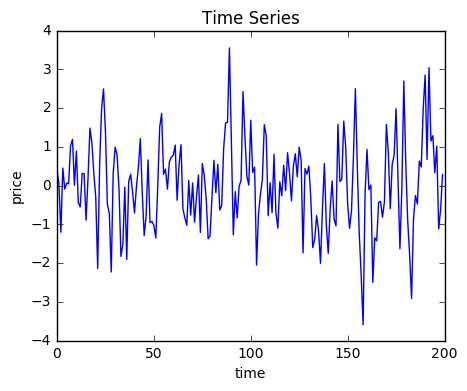

In [2]:
# generate a fake time series and plot it
from src.ts_gen import ar1_gen
Y = ar1_gen(0.5, sigma = 1.0, time = 200, num = 1, burnin = 2000)
plt.plot(Y.T)
plt.xlabel('time')
plt.ylabel('price')
plt.title('Time Series')
plt.show()

# add acf

In [3]:
# initialize the model
lag = 1
sigma = 2.0
intercept = 0.1
phi = np.random.randn(lag, 1)
AR_model = AR(lag=lag, phi=phi, sigma=sigma, intercept=intercept)

In [4]:
# check whether the gradients are properly calculated
_, grads = AR_model.loss(Y)

# define a useful mathod for future use
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


d_phi = grads['phi']
d_intercept = grads['intercept']

d_sigma = grads['sigma']

d_phi_num = eval_numerical_gradient_array(lambda phi: AR_model.loss(Y, lag,phi,sigma,intercept)[0], phi, 1)
print 'd_phi error: ', rel_error(d_phi_num, d_phi)

d_intercept_num = eval_numerical_gradient_array(lambda intercept: AR_model.loss(Y, lag,phi,sigma,intercept)[0], intercept, 1)
print 'd_intercept error: ', rel_error(d_intercept_num, d_intercept)

d_sigma_num = eval_numerical_gradient_array(lambda sigma: AR_model.loss(Y, lag,phi,sigma,intercept)[0], sigma, 1)
print 'd_sigma error: ', rel_error(d_sigma_num, d_sigma)

d_phi error:  1.96849013717e-11
d_intercept error:  4.95789977516e-11
d_sigma error:  1.7393596443e-11


In [5]:
# use the Solver to solve the AR model
AR_solver = Solver(AR_model, Y,
                          update_rule='sgd',
                          optim_config={
                            'learning_rate': 1e-5,},
                          num_epochs=3000, batch_size=1,
                          print_every=100)
AR_solver.train()
AR_model.params

3000
the loss is 350.345541
the loss is 344.910120
the loss is 339.388865
the loss is 333.814290
the loss is 328.231283
the loss is 322.699580
the loss is 317.295620
the loss is 312.112730
the loss is 307.258118
the loss is 302.844930
the loss is 298.978328
the loss is 295.736795
the loss is 293.153505
the loss is 291.205628
the loss is 289.818246
the loss is 288.882844
the loss is 288.282346
the loss is 287.912060
the loss is 287.690476
the loss is 287.560452
the loss is 287.484932
the loss is 287.441179
the loss is 287.415751
the loss is 287.400869


{'intercept': array([ 0.01354744]),
 'phi': array([[ 0.40321693]]),
 'sigma': array([ 1.02980021])}

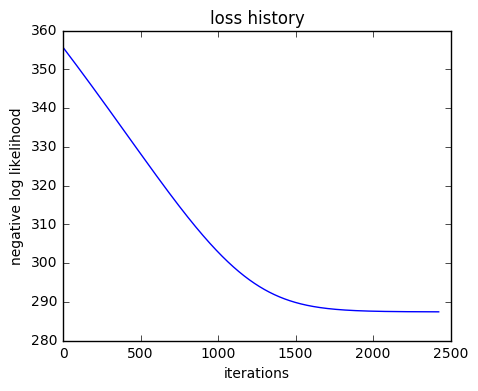

In [6]:
plt.plot(AR_solver.loss_history)
plt.xlabel('iterations')
plt.ylabel('negative log likelihood')
plt.title('loss history')
plt.show()

In [7]:
# initialize the model
lag = 1
sigma = 2.0
intercept = 0.1
phi = np.random.randn(1, 1)
AR_model = AR(lag=lag, phi=phi, sigma=sigma, intercept=intercept)

AR_solver_momentum = Solver(AR_model, Y,
                          update_rule='sgd_momentum',
                          optim_config={
                            'learning_rate': 1e-5,
                          },
                          
                          num_epochs=3000, batch_size=1,
                          print_every=100)
AR_solver_momentum.train()
AR_model.params

3000
the loss is 360.367048
the loss is 303.038408
the loss is 287.447062


{'intercept': array([ 0.00865851]),
 'phi': array([[ 0.41709862]]),
 'sigma': array([ 1.02529749])}

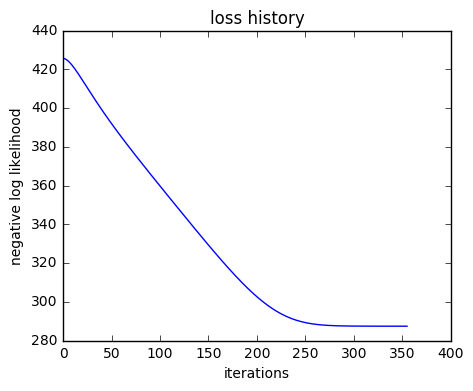

In [8]:
plt.plot(AR_solver_momentum.loss_history)
plt.xlabel('iterations')
plt.ylabel('negative log likelihood')
plt.title('loss history')
plt.show()

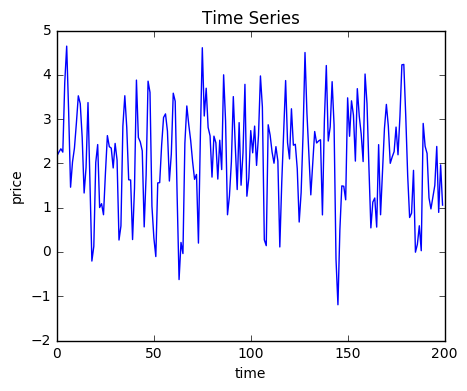

In [10]:
# generate a fake time series and plot it
from src.ts_gen import ma1_gen
Y = ma1_gen(0.5, constant = 2.0, time = 200, num = 1, burnin = 2000)
plt.plot(Y.T)
plt.xlabel('time')
plt.ylabel('price')
plt.title('Time Series')
plt.show()

# add acf

In [15]:
# initialize the model
lag = 1
sigma = 1.1
intercept = 2.0
phi = np.random.randn(lag, 1)
MA_model = MA(lag=lag, phi=phi, sigma=sigma, intercept=intercept)

# check whether the gradients are properly calculated
_, grads = MA_model.loss(Y)
print grads
MA_solver = Solver(MA_model, Y,
                          update_rule='sgd',
                          optim_config={
                            'learning_rate': 3e-4,
                          },
                          
                          num_epochs=3000, batch_size=1,
                          print_every=100)
MA_solver.train()
MA_model.params

{'phi': array([[ 1718.64412781]]), 'intercept': array(0.0), 'sigma': array(-2153.4999858204174)}


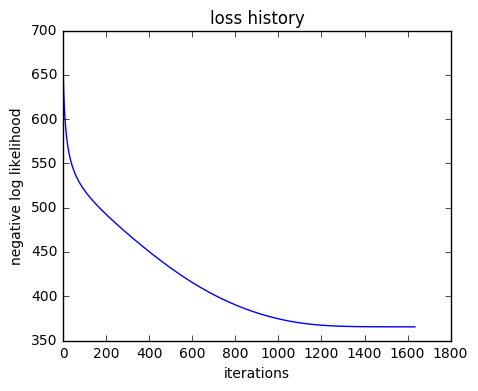

In [11]:
plt.plot(MA_solver.loss_history)
plt.xlabel('iterations')
plt.ylabel('negative log likelihood')
plt.title('loss history')
plt.show()